In [5]:
import sys
sys.path.append('/fast/lorenz/Programs/Total-Exchange-Flow/TotalExchangeFlow/')
from tef_core import *
import numpy as np
import pylab as plt
import xarray as xr

In [9]:
#recreate analytical example of Burchard et al. (2019) and Lorenz et al. (2019)
#define parameters
A=10000. #m^2 cross section
T=12*3600#s tidal period
omega=2*np.pi/T #Hz tidal frequency
u_r=-0.1 #m/s residual velocity (river discharge)
u_a = 1. #m/s tidal velocity amplitude
s_r = 20. #g/kg residual salinity
s_a = 10. #g/kg amplitude of salinity changes within one tidal cycle
phi = -np.arccos(-2*(u_r*s_r)/(u_a*s_a)) #phase lag between velocity and salt
N = 10000

#define analytical velocity and salinity function:
def u_vel_analytical(t):
    u=u_r+u_a*np.cos(2*np.pi*t)
    return(u)
    
def s_analytical(t):
    s = s_r + s_a*np.cos(2*np.pi*t+phi)
    return(s)

#define analytical solution according to Appendix of Lorenz et al. (2019):

def Q_analytical(S):
    t_1 = -1/omega*(np.arccos((S-s_r)/s_a)+phi)
    t_2 = 1/omega*(np.arccos((S-s_r)/s_a)-phi)
    #print(t_1,t_2)
    Q = A/T*(u_r*t_2+u_a/omega*np.sin(omega*t_2)-u_r*t_1-u_a/omega*np.sin(omega*t_1))
    return(Q)
    
def Qs_analytical(S):
    t_1 = -1/omega*(np.arccos((S-s_r)/s_a)+phi)
    t_2 = 1/omega*(np.arccos((S-s_r)/s_a)-phi)
    Qs = A/T*(u_r*s_r*(t_2-t_1)+u_a*s_r/omega*(np.sin(omega*t_2)-np.sin(omega*t_1)) + u_r*s_a/omega*(np.sin(omega*t_2 + phi)-np.sin(omega*t_1+phi))\
    +u_a*s_a/2*np.cos(phi)*(t_2-t_1 + 1/omega *np.sin(omega*t_2)*np.cos(omega*t_2) - 1/omega *np.sin(omega*t_1)*np.cos(omega*t_1))\
    -u_a*s_a*np.sin(phi)/2/omega*(np.sin(omega*t_2)**2 - np.sin(omega*t_1)**2))
    return(Qs)    
    
def q_analytical(S):
    q=A/(T*omega)*1/(np.sqrt(s_a**2-(S-s_r)**2))*(-2*u_r-u_a*np.cos(np.arccos((S-s_r)/s_a)-phi)-u_a*np.cos(np.arccos((S-s_r)/s_a)+phi))
    return(q)


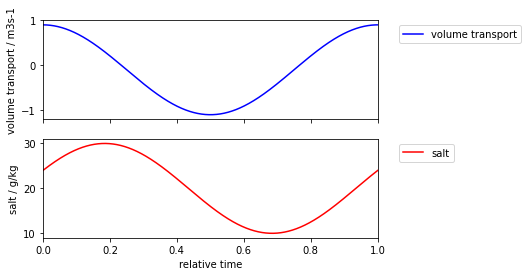

In [33]:
#create the discrete values for time, volume transport, salt, and salt transport for N discrete value:
t = np.float64(np.arange(0,1,1/N)) #time array (0 to 1 , so relative to one Tidal cycle T)
volume_transport = np.float64(u_vel_analytical(t)) #volume transport
salt = np.float64(s_analytical(t)) #salt / salinity
salt_transport=np.float64(uu*ss) #salt transport

### put everything into a xr.Dataset

data = xr.Dataset({
"salt": (["time"], salt),
"volume_transport": (["time"], volume_transport),
"salt_transport": (["time"], salt_transport)},
coords={
    "time": (["time"], t),
})

#show the data

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(t,volume_transport,color='blue',label='volume transport')
ax[0].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[0].set_ylabel('volume transport / m3s-1')
ax[1].plot(t,salt,color='red',label='salt')
ax[1].set_ylabel('salt / g/kg')
ax[1].set_xlabel('relative time')
ax[1].set_xlim(0,1)
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1))

In [38]:
### to the TEF analysis with the package
tef = TEF_object(ds=data)

###sort into salinity classes. From the paper and the data we know what s_min and s_max should be:
s_min  = 10.0
s_max  = 31.0
N_bins = 1024
out = tef.sort_1dim(tef.ds.salt,
                  transport = tef.ds.volume_transport,
                  N=N_bins,
                  minmaxrange=(s_min,s_max))

ValueError: None not found in array dimensions ('time',)

In [39]:
data

<xarray.Dataset>
Dimensions:           (time: 10000)
Coordinates:
  * time              (time) float64 0.0 0.0001 0.0002 ... 0.9997 0.9998 0.9999
Data variables:
    salt              (time) float64 24.0 24.01 24.01 ... 23.98 23.99 23.99
    volume_transport  (time) float64 0.9 0.9 0.9 0.9 0.9 ... 0.9 0.9 0.9 0.9 0.9
    salt_transport    (time) float64 21.6 21.61 21.61 21.62 ... 21.59 21.59 21.6